In [2]:
import pandas as pd
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,cross_validate,train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import precision_recall_curve,average_precision_score,precision_score,recall_score,accuracy_score
import time
import matplotlib.pyplot as plt

import io


# uploaded = files.upload()
# #extract the data
# raw_df = pd.read_csv(io.BytesIO(uploaded['BitcoinHeistData.csv']))

raw_df = pd.read_csv("~/ML_class_projects/a_1/BitcoinHeistData.csv")
cleaned_df = raw_df.copy()
#clean the data
cleaned_df['class']=np.array([0 if x=='white' else 1 for x in cleaned_df.pop('label')])
eps=0.001 # 0 => 0.1¢
cleaned_df['Log income'] = np.log(cleaned_df.pop('income')+eps)
cleaned_df['Log weight'] = np.log(cleaned_df.pop('weight')+eps)
cleaned_df.pop("address")
cleaned_df.pop("year")
cleaned_df.pop("day")
print(cleaned_df.head(5))


#summarize the data distribution
y=np.array(cleaned_df['class'])
X=np.array(cleaned_df.iloc[:,:-1])
print(Counter(y))

#rescale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


#define the undersampling method
under = RandomUnderSampler(sampling_strategy=0.5)



   length  count  looped  neighbors  class  Log income  Log weight
0      18      1       0          2      1   18.421181   -4.674163
1      44      1       0          1      1   18.420681   -6.689310
2       0      1       0          2      1   19.113828    0.001000
3      72      1       0          2      1   18.081003   -5.317245
4     144    456       0          1      1   19.113828   -2.605741
Counter({0: 2875284, 1: 41413})


NameError: name 'recall_train_score_list' is not defined

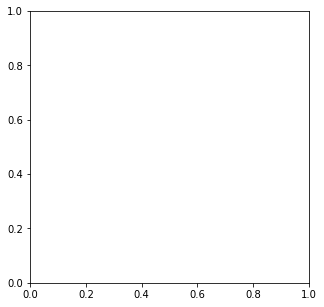

In [3]:
##cross validation to find out the best neighbor number using kd_tree or ball_tree###
t=7
cv = KFold(n_splits=t,shuffle=True)
AP_train_score_list=[]
AP_test_score_list=[]

neighbors_num = [3,4,5,6,7]
algorithms = ['kd_tree','ball_tree']
# parameters=(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)[source]
for neighbors in neighbors_num:
    neigh = KNeighborsClassifier(n_neighbors=neighbors,weights='distance',algorithm='kd_tree')
    steps = [('under',under),('model',neigh)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
    AP_train_score_list.append(sum(scores['train_average_precision'])/t)
    AP_test_score_list.append(sum(scores['test_average_precision'])/t)
    

# #generate Fig_1.5.0.
fig_0, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
axs.plot(neighbors_num,AP_train_score_list,"r^",linestyle = "--", label='training data')
axs.plot(neighbors_num,AP_test_score_list,"b^",linestyle = "--",label='test data')
axs.set_xlabel("neighbors_num")
axs.set_ylabel("AP score")
axs.legend()
fig_0.suptitle("Fig_1.5.0: AP_score(kd_tree)")
fig_0.savefig("KNN_fig_1.5_tunning:AP score.png")




In [ ]:
########check if using ball_tree can get higher AP score######
# neigh = KNeighborsClassifier(n_neighbors=**********,weights='distance',algorithm='ball_tree')
# steps = [('under',under),('model',neigh)]
# pipeline = Pipeline(steps=steps)
# scores =  cross_validate(pipeline, X, y, scoring=['average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
# print("AP_score on training set if using ball_tree to store:",sum(scores['train_average_precision'])/t)
# print("AP_score on test set if using ball_tree to store:",sum(scores['test_average_precision'])/t)
    

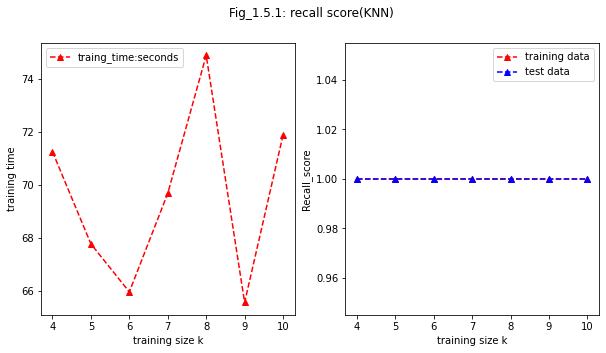

In [6]:
###############Apply neighbors_num and storing methods to train the model##################
Recall_train_score=[]
Recall_test_score=[]
training_time = []

for k in range(4,11):
    cv = KFold(n_splits=k,shuffle=True)
    neigh = KNeighborsClassifier(n_neighbors=3,weights='distance',algorithm='kd_tree')
    steps = [('under',under),('model',neigh)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['recall'], cv=cv, n_jobs=-1,return_train_score=True)
    Recall_train_score.append(sum(scores['train_recall'])/k)
    Recall_test_score.append(sum(scores['test_recall'])/k)
    training_time.append(sum(scores['fit_time'])/k)
    
K= range(4,11)
##generate Fig_1.5.1
fig_1, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axs[0].plot(K,training_time,"r^",linestyle = "--",label="traing_time:seconds")
axs[0].set_xlabel("training size k")
axs[0].set_ylabel("training time")
axs[1].plot(K,Recall_train_score,"r^",linestyle = "--",label='training data')
axs[1].plot(K,Recall_test_score,"b^",linestyle = "--",label='test data')
axs[1].set_xlabel("training size k")
axs[1].set_ylabel("Recall_score")
axs[0].legend()
axs[1].legend()
fig_1.suptitle("Fig_1.5.1: recall score(KNN)")
fig_1.savefig("NN_fig_1.5_trainnig:learning curves.png")
    

In [8]:
##################prediction results, generate the data in table1.5.0#########
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/9, random_state=123)
neigh = KNeighborsClassifier(n_neighbors=3,weights='distance',algorithm='kd_tree')
X_train_under,y_train_under=under.fit_resample(X_train,y_train)
neigh.fit(X_train_under,y_train_under)
y_train_predict_proba=neigh.predict_proba(X_train)[:,1]
y_test_predict_proba =neigh.predict_proba(X_test)[:,1]

print("The AP scores on training set and test set are",average_precision_score(y_train,y_train_predict_proba),average_precision_score(y_test,y_test_predict_proba))
print("The recall scores on training set and test set are",recall_score(y_train,neigh.predict(X_train)),recall_score(y_test,neigh.predict(X_test)))
      
      
          
      
      

The AP scores on training set and test set are 1.0 1.0
The recall scores on training set and test set are 1.0 1.0


In [10]:
sum(neigh.predict(X_train))+sum(neigh.predict(X_test))

41413